# Siren Exploration

This is a colab to explore properties of the Siren MLP, proposed in our work [Implicit Neural Activations with Periodic Activation Functions](https://vsitzmann.github.io/siren).

**Heavily edited by blackle mori. click on the link above for the original paper and colab notebook**


We will first implement a streamlined version of Siren for fast experimentation. This lacks the code to easily do baseline comparisons - please refer to the main code for that - but will greatly simplify the code!

**Make sure that you have enabled the GPU under Edit -> Notebook Settings!**

We will then reproduce the following results from the paper: 
* [Fitting an image](#section_1)
* [Fitting an audio signal](#section_2)
* [Solving Poisson's equation](#section_3)
* [Initialization scheme & distribution of activations](#activations)
* [Distribution of activations is shift-invariant](#shift_invariance)

We will also explore Siren's [behavior outside of the training range](#out_of_range).

Let's go! First, some imports, and a function to quickly generate coordinate grids.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def get_lfgrid(sidelen, x, y, fov):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    fov = np.tan(np.radians(180-fov) / 2)
    fov = torch.ones(sidelen, sidelen)*fov
    x = torch.ones(sidelen, sidelen)*x
    y = torch.ones(sidelen, sidelen)*y
    
    mgrid = torch.stack(tuple([x, y]), dim=-1)
    tensors = tuple(2 * [torch.linspace(-1, 1, steps=sidelen)])
    dirgrid = torch.cat([torch.stack(torch.meshgrid(*tensors), dim=-1), fov[:, :, None]], dim=2)
    dirgrid /= dirgrid.norm(dim=2, keepdim=True)
    grid = torch.cat([mgrid, dirgrid], dim=2)
    grid = grid.reshape(-1, 5)
    return grid

In [2]:
import OpenEXR as exr
import Imath

def readEXR(filename):
    """Read color + depth data from EXR image file.
    
    Parameters
    ----------
    filename : str
        File path.
        
    Returns
    -------
    img : RGB or RGBA image in float32 format. Each color channel
          lies within the interval [0, 1].
          Color conversion from linear RGB to standard RGB is performed
          internally. See https://en.wikipedia.org/wiki/SRGB#The_forward_transformation_(CIE_XYZ_to_sRGB)
          for more information.
          
    Z : Depth buffer in float32 format or None if the EXR file has no Z channel.
    """
    
    exrfile = exr.InputFile(filename)
    header = exrfile.header()
    
    dw = header['dataWindow']
    isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)
    
    channelData = dict()
    
    # convert all channels in the image to numpy arrays
    for c in header['channels']:
        C = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
        C = np.fromstring(C, dtype=np.float32)
        C = np.reshape(C, isize)
        
        channelData[c] = C
    
    colorChannels = ['R', 'G', 'B', 'A'] if 'A' in header['channels'] else ['R', 'G', 'B']
    img = np.concatenate([channelData[c][...,np.newaxis] for c in colorChannels], axis=2)
    
    # linear to standard RGB
    img[..., :3] = np.where(img[..., :3] <= 0.0031308,
                            12.92 * img[..., :3],
                            1.055 * np.power(img[..., :3], 1 / 2.4) - 0.055)
    
    # sanitize image to be in range [0, 1]
    img = np.where(img < 0.0, 0.0, np.where(img > 1.0, 1, img))
    
    Z = None if 'Z' not in header['channels'] else channelData['Z']
    
    return img, Z

Now, we code up the sine layer, which will be the basic building block of SIREN. This is a much more concise implementation than the one in the main code, as here, we aren't concerned with the baseline comparisons.

In [3]:
from scipy.linalg import hadamard
from math import sqrt
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30, has_skip=False, skip_idx=1):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.has_skip = has_skip
        self.skip_idx = skip_idx
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1. / self.in_features, 
                                             1. / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        intermediate = torch.sin(self.omega_0 * self.linear(input))
        if self.has_skip:
            intermediate = intermediate/self.skip_idx + input
        return intermediate
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 omega=30, first_linear=False):
        super().__init__()
        self.omega = omega
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_layers = hidden_layers
        self.hidden_features = hidden_features
        self.first_linear=first_linear
        self.net = []
        if first_linear:
            linear = nn.Linear(in_features, hidden_features)
            with torch.no_grad():
                linear.weight.uniform_(-1. / self.in_features / omega, 
                                        1. / self.in_features / omega) 
            self.net.append(linear)
        else:
            self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=omega))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=omega, has_skip=True, skip_idx=sqrt(i+1)))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / omega, 
                                              np.sqrt(6 / hidden_features) / omega)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=omega))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

# Experiments

For the image fitting and poisson experiments, we'll use the classic cameraman image.

In [4]:
from skimage import io
def get_image_tensor(sidelength, filename, grey=False):
    img = Image.fromarray(skimage.io.imread(filename, as_gray=grey))
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

<a id='section_1'></a>
## Fitting an image

First, let's simply fit that image!

We seek to parameterize a greyscale image $f(x)$ with pixel coordinates $x$ with a SIREN $\Phi(x)$.

That is we seek the function $\Phi$ such that:
$\mathcal{L}=\int_{\Omega} \lVert \Phi(\mathbf{x}) - f(\mathbf{x}) \rVert\mathrm{d}\mathbf{x}$
 is minimized, in which $\Omega$ is the domain of the image. 
 
We write a little datast that does nothing except calculating per-pixel coordinates:

In [5]:
class ImageFitting(Dataset):
    def __init__(self, sidelength, pattern, xcount, ycount, fov, grey=False):
        super().__init__()
        self.pixels = None
        self.coords = None
        for y in range(ycount):
            for x in range(xcount):
                num = x + y*xcount + 1
                filename = pattern % ("", num, "jpg")
                normal = pattern % ("normal", num, "jpg")
                exr = pattern % ("", num, "exr")
                print("loading", filename)
                img = get_image_tensor(sidelength, filename, grey=grey)
                N = get_image_tensor(sidelength, normal)
                _, Z = readEXR(exr)
                maxZ = 25
                Z = np.where(Z >= maxZ, maxZ, Z)
                Z = torch.from_numpy(Z)/maxZ*2-1
                Z = Z.view(-1, 1)
                p = img.permute(1, 2, 0).view(-1, 1 if grey else 3)
                N = N.permute(1, 2, 0).view(-1, 3)
                p = torch.cat([p, N, Z], dim=1)
                c = get_lfgrid(sidelength, x/(xcount-1)*2-1, y/(ycount-1)*2-1, fov)
                if self.coords is None or self.pixels is None:
                    self.pixels = p
                    self.coords = c
                else:
                    self.pixels = torch.cat([self.pixels, p])
                    self.coords = torch.cat([self.coords, c])
        print(self.pixels.shape, self.coords.shape)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

Let's instantiate the dataset and our Siren. As pixel coordinates are 2D, the siren has 2 input features, and since the image is grayscale, it has one output channel.

In [7]:
field = ImageFitting(256, "lightfield/%s%04d.%s", 2, 2, 120, grey=False)
fieldloader = DataLoader(field, batch_size=1, pin_memory=False, num_workers=0)

loading lightfield/0001.jpg
loading lightfield/0002.jpg
loading lightfield/0003.jpg
loading lightfield/0004.jpg
torch.Size([262144, 7]) torch.Size([262144, 5])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


We now fit Siren in a simple training loop. Within only hundreds of iterations, the image and its gradients are approximated well.

In [10]:
import re

def dump_data(dat):
  dat = dat.cpu().detach().numpy()
  return dat

def print_vec4(ws):
  vec = "vec4(" + ",".join(["{0:.3f}".format(w) for w in ws]) + ")"
  vec = re.sub(r"\b0\.", ".", vec)
  return vec

def print_mat4(ws):
  mat = "mat4(" + ",".join(["{0:.3f}".format(w) for w in np.transpose(ws).flatten()]) + ")"
  mat = re.sub(r"\b0\.", ".", mat)
  return mat

def serialize_to_shadertoy(siren, varname):
  #first layer
  omega = siren.omega
  chunks = int(siren.hidden_features/4)
  lin = siren.net[0] if siren.first_linear else siren.net[0].linear
  in_w = dump_data(lin.weight)
  in_bias = dump_data(lin.bias)
  om = 1 if siren.first_linear else omega
  for row in range(chunks):
    if siren.first_linear:
        line = "vec4 %s0_%d=(" % (varname, row)
    else:
        line = "vec4 %s0_%d=sin(" % (varname, row)

    for ft in range(siren.in_features):
        feature = x_vec = in_w[row*4:(row+1)*4,ft]*om
        line += ("ft_%d*" % ft) + print_vec4(feature) + "+"
    bias = in_bias[row*4:(row+1)*4]*om
    line += print_vec4(bias) + ");"
    print(line)

  #hidden layers
  for layer in range(siren.hidden_layers):
    layer_w = dump_data(siren.net[layer+1].linear.weight)
    layer_bias = dump_data(siren.net[layer+1].linear.bias)
    for row in range(chunks):
      line = ("vec4 %s%d_%d" % (varname, layer+1, row)) + "=sin("
      for col in range(chunks):
        mat = layer_w[row*4:(row+1)*4,col*4:(col+1)*4]*omega
        line += print_mat4(mat) + ("*%s%d_%d"%(varname, layer, col)) + "+\n    "
      bias = layer_bias[row*4:(row+1)*4]*omega
      line += print_vec4(bias)+")/%0.1f+%s%d_%d;"%(sqrt(layer+1), varname, layer, row)
      print(line)

  #output layer
  out_w = dump_data(siren.net[-1].weight)
  out_bias = dump_data(siren.net[-1].bias)
  for outf in range(siren.out_features):
    line = "float %s_%d=" % (varname, outf)
    for row in range(chunks):
      vec = out_w[outf,row*4:(row+1)*4]
      line += ("dot(%s%d_%d,"%(varname, siren.hidden_layers, row)) + print_vec4(vec*.5) + ")+\n    "
    print(line + "{:0.3f}".format(out_bias[outf]*.5+.5)+";")

serialize_to_shadertoy(field_siren, "f")

vec4 f0_0=sin(ft_0*vec4(-.382,-.046,-.374,.380)+ft_1*vec4(.035,-.042,-.441,-.497)+ft_2*vec4(-.430,1.871,-.111,-1.433)+ft_3*vec4(.048,-.209,-.503,-.338)+ft_4*vec4(-1.379,1.208,.051,-.359)+vec4(-1.878,1.582,-.195,-1.157));
vec4 f0_1=sin(ft_0*vec4(.310,-.099,-.544,-.081)+ft_1*vec4(.109,.516,.152,-.185)+ft_2*vec4(-.005,1.123,.649,-1.985)+ft_3*vec4(-.216,-.667,-.218,-.323)+ft_4*vec4(-.257,-.563,-.254,-.335)+vec4(-.833,2.866,.218,1.000));
vec4 f0_2=sin(ft_0*vec4(-.068,.067,-.436,-.081)+ft_1*vec4(.288,.596,.161,-.571)+ft_2*vec4(.909,-.219,-.459,-.213)+ft_3*vec4(-.165,.746,-1.686,-1.207)+ft_4*vec4(1.832,1.051,-.162,.248)+vec4(1.759,.463,-2.162,-.412));
vec4 f0_3=sin(ft_0*vec4(.139,-.218,.266,.375)+ft_1*vec4(.454,.391,.051,.140)+ft_2*vec4(.572,1.421,1.678,1.243)+ft_3*vec4(1.163,-1.260,.756,.800)+ft_4*vec4(-.406,-.556,-.515,.352)+vec4(.057,.318,2.259,-.231));
vec4 f0_4=sin(ft_0*vec4(-.127,-.178,-.142,-.278)+ft_1*vec4(.181,-.228,-.562,.472)+ft_2*vec4(.137,-.694,.784,1.866)+ft_3*vec4(.026,-.106,.5

First we train the black and white version of the cat

In [25]:
import copy

def train_siren(dataloader, out_features, hidden_features, hidden_layers, omega):
  model_input, ground_truth = next(iter(dataloader))
  model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

  img_curr = Siren(in_features=5, out_features=out_features, hidden_features=hidden_features, 
                   hidden_layers=hidden_layers, outermost_linear=True, omega=omega, first_linear=False)
  img_curr.cuda()
  #optim = torch.optim.Adagrad(params=img_curr.parameters())
  #optim = torch.optim.Adam(lr=1e-3, params=img_curr.parameters())
  optim = torch.optim.Adam(lr=1e-3, params=img_curr.parameters(), weight_decay=.01)
  perm = torch.randperm(model_input.size(1))

  total_steps = 20000
  update = int(total_steps/50)
  batch_size = 256*256
  for step in range(total_steps):
    if step == int(total_steps/4):
        optim.param_groups[0]['weight_decay'] = 0.
    idx = step % int(model_input.size(1)/batch_size)
    model_in = model_input[:,perm[batch_size*idx:batch_size*(idx+1)],:]
    truth = ground_truth[:,perm[batch_size*idx:batch_size*(idx+1)],:]
    model_output, coords = img_curr(model_in)
    loss = None
    #loss = (model_output - truth)**4
    loss = (model_output - truth)**2
    #loss = (model_output - truth)**4 * (1-terp) + ((model_output - truth)**2*.8+abs(model_output - truth)*.2) * terp
    #loss = abs(model_output - truth)*.1 + (model_output - truth)**2*.9
    #loss = abs(model_output - truth)*.5 + (model_output - truth)**4
    #loss[:,:,0] *= abs(model_in[:,:,4])*+1
    #loss[:,:,1] *= abs(model_in[:,:,4])*+1
    #loss[:,:,2] *= abs(model_in[:,:,4])*+1
    loss = loss.mean()

    optim.zero_grad()
    loss.backward()
    optim.step()
           
    if (step % update) == update-1:  
      del model_output, coords, model_in
      #perm = torch.randperm(model_input.size(1))
      print("Step %d, Current loss %0.6f" % (step, loss))
      fig, ax = plt.subplots(figsize=(5,5))
      coords = get_lfgrid(256, 0, 0, 120).cuda()
      sample, _ = img_curr(coords)
      smp = sample.cpu().view(256,256,out_features).detach().numpy()
      if out_features == 1:
        smp = smp.reshape(256,256)
      if out_features > 3:
        smp = smp[:,:,0:3]
      ax.imshow(smp*.5+.5)
      #ax[1].imshow(smp[:,:,3:6]*.5+.5)
      #axes[1].imshow((model_output - truth).cpu().view(256,256).detach().numpy(), cmap='gray', vmin=-1, vmax=1)
      plt.show()

  return img_curr

Step 399, Current loss 0.015991


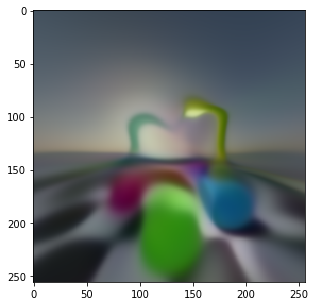

Step 799, Current loss 0.011657


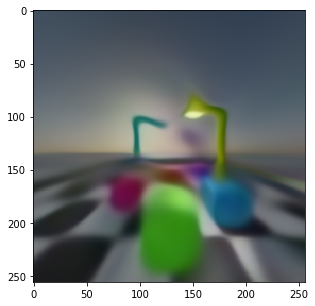

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1199, Current loss 0.010846


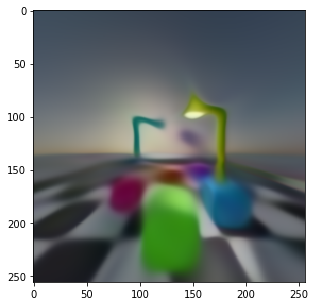

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1599, Current loss 0.009995


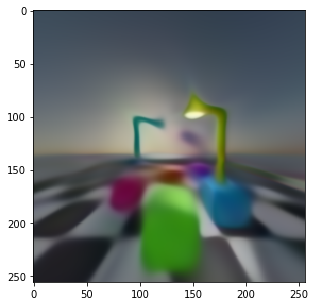

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1999, Current loss 0.009892


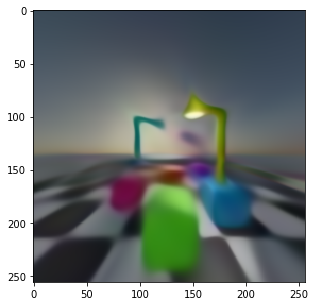

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2399, Current loss 0.009349


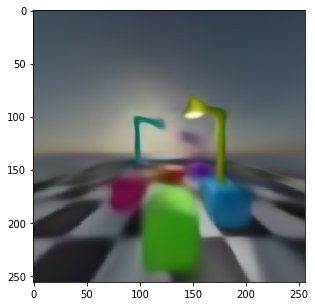

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2799, Current loss 0.009110


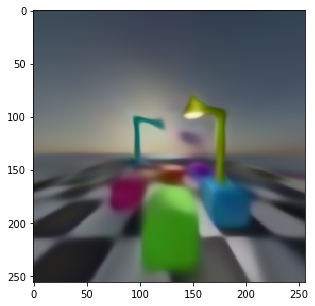

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3199, Current loss 0.008740


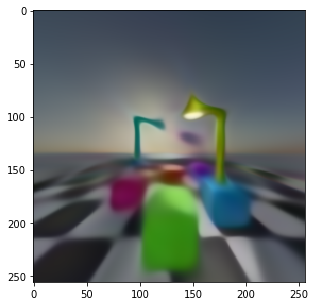

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3599, Current loss 0.008770


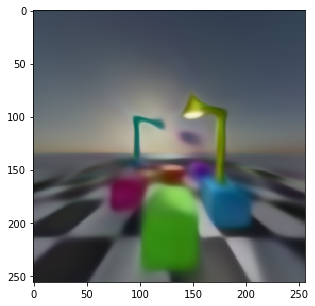

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3999, Current loss 0.008570


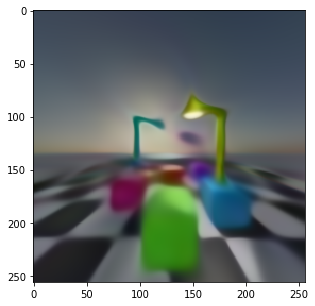

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4399, Current loss 0.008464


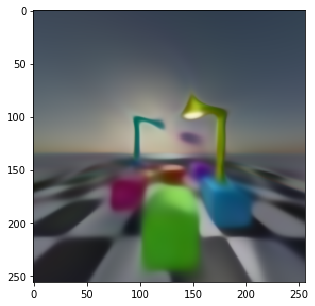

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4799, Current loss 0.008439


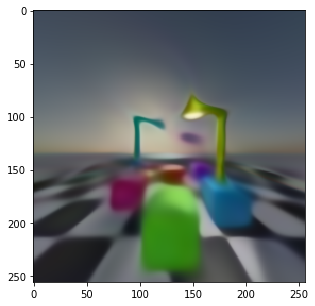

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5199, Current loss 0.006268


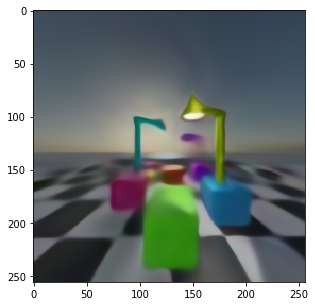

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5599, Current loss 0.005399


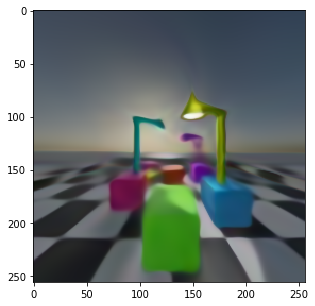

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5999, Current loss 0.005269


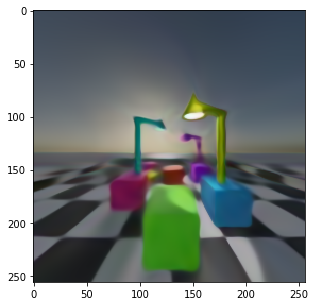

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6399, Current loss 0.004122


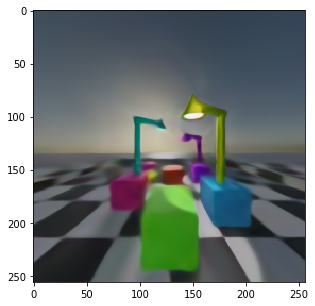

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6799, Current loss 0.003919


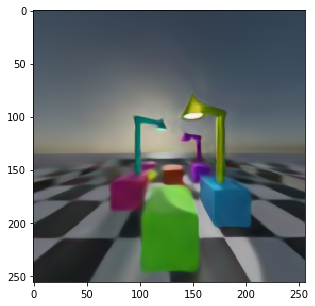

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7199, Current loss 0.003599


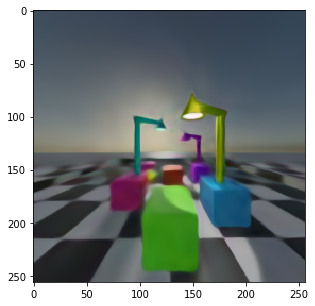

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7599, Current loss 0.003529


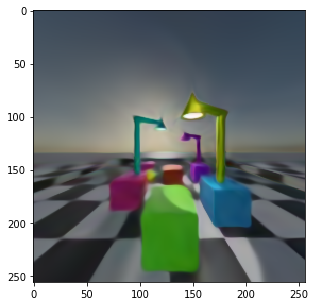

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7999, Current loss 0.003527


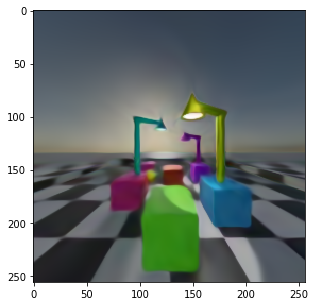

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8399, Current loss 0.003265


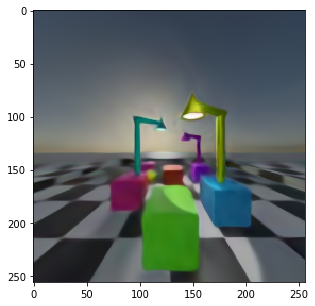

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8799, Current loss 0.003379


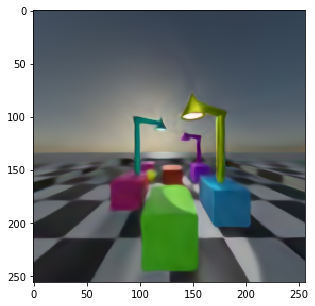

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9199, Current loss 0.004024


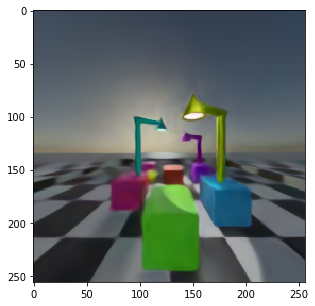

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9599, Current loss 0.003705


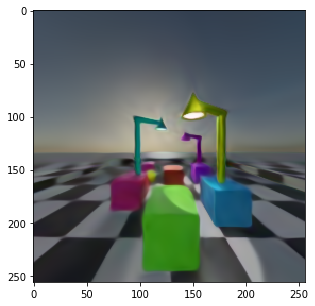

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9999, Current loss 0.003607


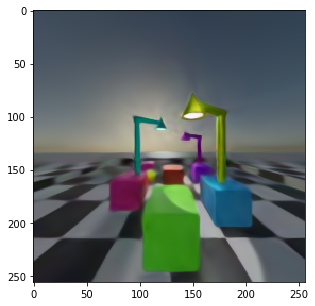

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10399, Current loss 0.003295


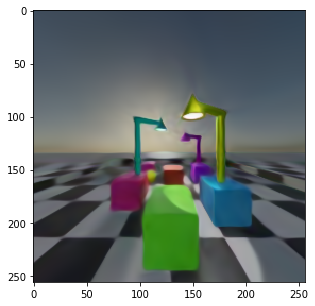

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10799, Current loss 0.003179


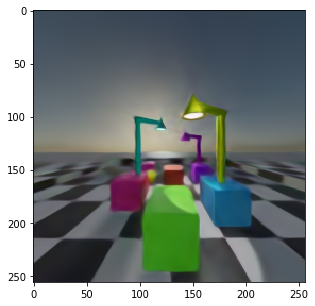

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11199, Current loss 0.003426


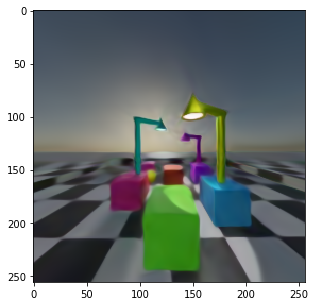

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11599, Current loss 0.003544


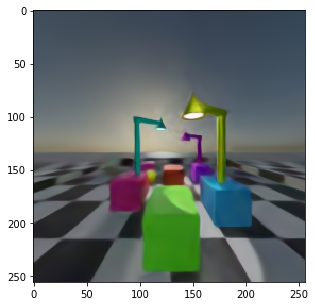

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11999, Current loss 0.003325


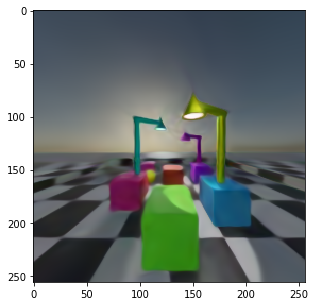

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12399, Current loss 0.003473


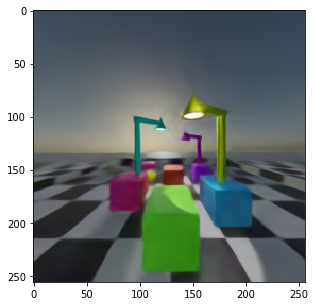

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12799, Current loss 0.003134


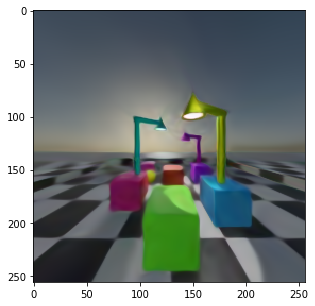

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13199, Current loss 0.003090


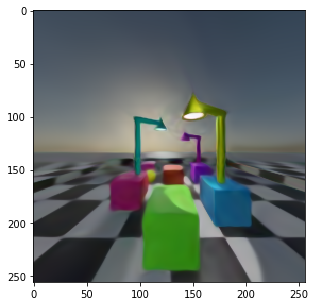

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13599, Current loss 0.003107


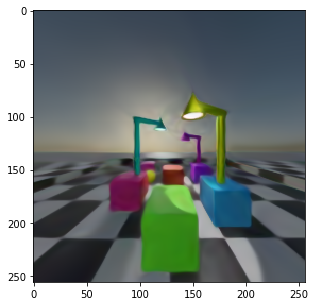

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13999, Current loss 0.003089


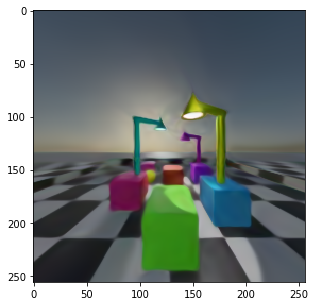

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14399, Current loss 0.003169


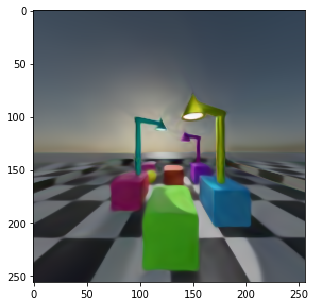

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14799, Current loss 0.002833


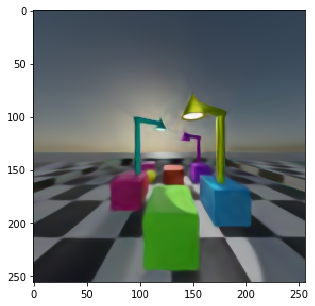

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15199, Current loss 0.002855


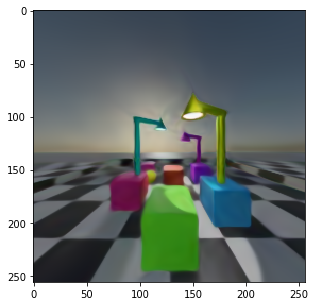

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15599, Current loss 0.002872


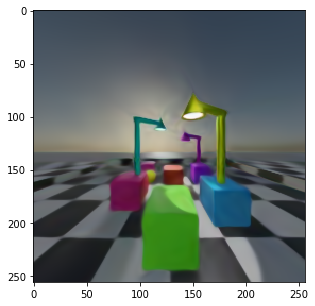

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15999, Current loss 0.003168


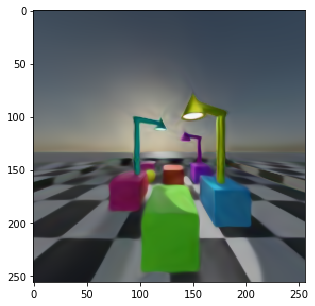

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16399, Current loss 0.003008


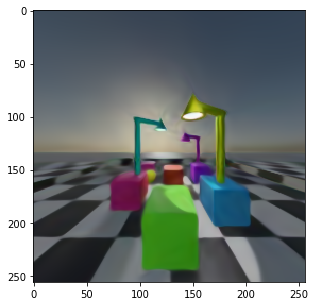

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16799, Current loss 0.003142


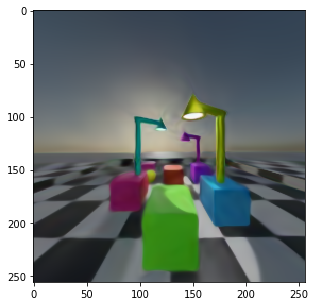

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17199, Current loss 0.003129


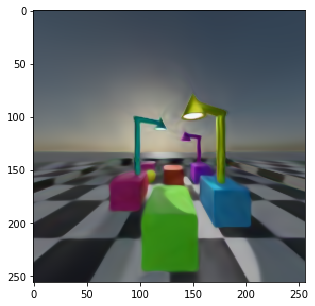

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17599, Current loss 0.002717


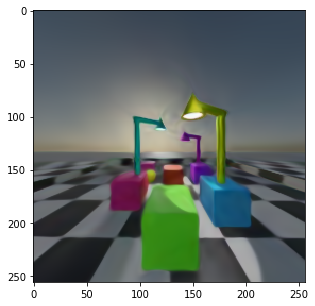

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17999, Current loss 0.002768


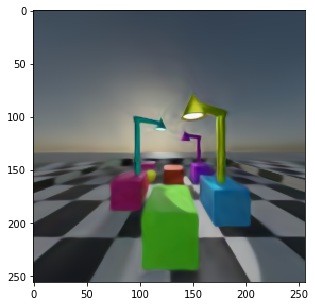

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18399, Current loss 0.003221


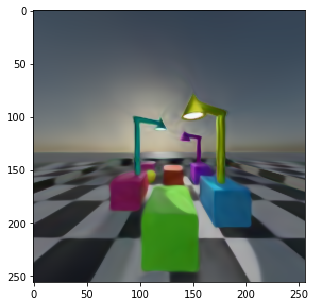

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18799, Current loss 0.002961


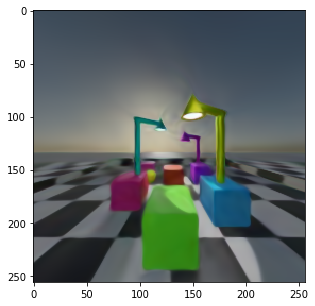

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19199, Current loss 0.002631


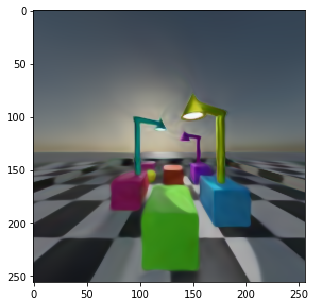

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19599, Current loss 0.003133


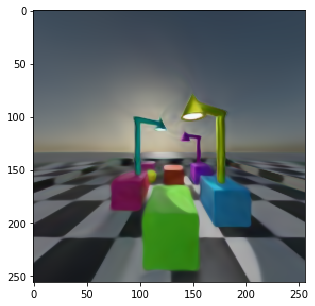

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19999, Current loss 0.002942


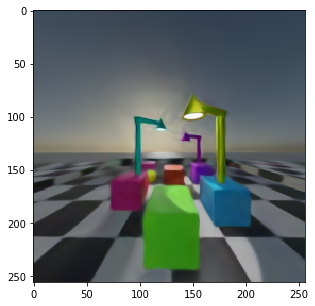

vec4 f0_0=sin(ft_0*vec4(.635,.201,-.050,-.360)+ft_1*vec4(.107,.557,-.236,.323)+ft_2*vec4(-.137,-.296,-.003,.903)+ft_3*vec4(1.461,.460,.487,-.051)+ft_4*vec4(-2.409,-.025,-2.808,-1.707)+vec4(-4.695,-.034,-2.749,-2.356));
vec4 f0_1=sin(ft_0*vec4(-.105,-.113,.478,.023)+ft_1*vec4(-.307,.585,.212,.107)+ft_2*vec4(.130,-.352,1.920,-.123)+ft_3*vec4(.003,.044,1.103,-.069)+ft_4*vec4(1.548,1.030,1.436,-.315)+vec4(1.991,1.005,2.686,.259));
vec4 f0_2=sin(ft_0*vec4(.161,-.559,.372,.012)+ft_1*vec4(.569,-.281,-.220,.248)+ft_2*vec4(.529,-.949,-.460,2.395)+ft_3*vec4(-.449,-2.232,-1.368,-.232)+ft_4*vec4(-.443,.113,-.953,.948)+vec4(-.211,2.216,-1.718,-3.379));
vec4 f0_3=sin(ft_0*vec4(-.278,-.249,.175,-.172)+ft_1*vec4(.347,.641,-.417,.016)+ft_2*vec4(-.096,2.752,-.617,1.743)+ft_3*vec4(-1.684,-1.638,-.109,-1.853)+ft_4*vec4(-.176,-.627,-1.468,-1.219)+vec4(.865,-.189,-2.005,-4.060));
vec4 f0_4=sin(ft_0*vec4(-.091,.235,-.257,.300)+ft_1*vec4(-.425,.345,.312,-.736)+ft_2*vec4(-2.754,1.560,.049,-2.412)+ft_3*vec4(.19

In [29]:
field_siren = train_siren(fieldloader, 7, 20, 20, 15)
serialize_to_shadertoy(field_siren, "f")


And then we train a colour map for the cat (this will be passed into a colour gradient)

In [ ]:
with torch.no_grad():
    out_of_range_coords = get_mgrid(1024, 2)
    model_out, _ = cat_siren(out_of_range_coords.cuda())
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(model_out.cpu().view(1024,1024).numpy(), cmap='gray', vmin=-1, vmax=1)
    plt.show()